In [10]:
#Import dependencies
from scipy.ndimage import rotate
import numpy as np
#%matplotlib notebook
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os

from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd

In [11]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

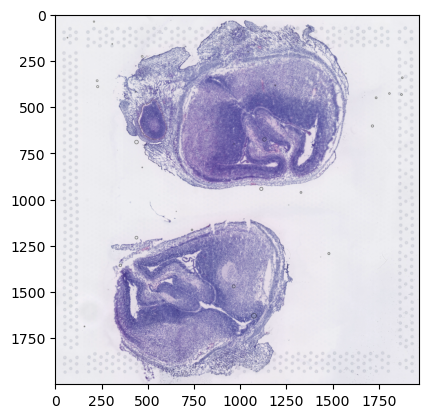

In [12]:
image_file = '../visium_data/tissue_hires_image_test.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [13]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (2000, 1968, 3)
The range of V is 0.16862745583057404 to 1.0
The range of V after normalization is 0.0 to 1.0


In [21]:

J = Vnorm.transpose(2,0,1)
J=J[0:200,1000:2000,300:1300]
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 1000, 1000)


In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
#==================================
# load image (4D) [X,Y,Z_slice,time]
nii_img  = nib.load('../E13-5_MRI_34um/E13-5_LSFM_20um_masked_1.nii.gz')
nii_data = nii_img.get_fdata()


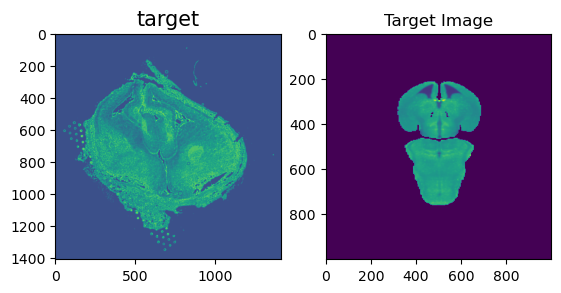

In [19]:
from scipy.ndimage import rotate
I=nii_data[:,170,:]
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
fig,ax = plt.subplots(1,2)
theta_deg = 90
theta_deg2 = -50
extentA = STalign.extent_from_x((YJ,XJ))
ax[0].imshow(rotate((J).transpose(1,2,0), angle=theta_deg2))
ax[0].set_title('target', fontsize=15)
ax[1].imshow(rotate(I, angle=theta_deg),extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    

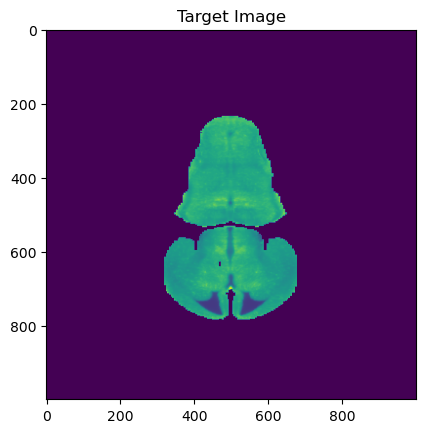

In [16]:
from scipy.ndimage import rotate

theta_deg = -90

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
fig,ax = plt.subplots(1)
extentA = STalign.extent_from_x((YJ,XJ))
ax.imshow(rotate(nii_data[:,172,:], angle=theta_deg),extent=extentA)
ax.set_title('Target Image')
fig.canvas.draw()   

In [9]:

 
# printing original list

 
# Convert Matrix to Coordinate Dictionary
# Using loop + enumerate()
res = dict()
for idx, sub in enumerate(J):
    for j, ele in enumerate(sub):
        if ele in res:
            res[ele].add((idx, j))
        else:
            res[ele] = {(idx, j)}
 
# printing result 
print("The Coordinate Dictionary : " + str(res)) 

TypeError: unhashable type: 'numpy.ndarray'

In [23]:
X_=np.arange(0, 1000, 1)
Y_=np.arange(0, 1000, 1)
W=J[1,:,:]
W[W > 0.8] = 0
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

In [24]:
sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
muB = torch.tensor([0,0,0],device='cpu') #average of background intensities


Text(0.5, 1.0, 'Intensity Histogram of Target Image')

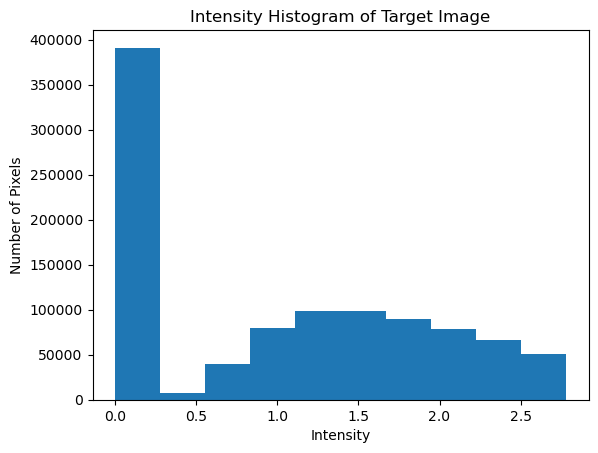

In [25]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [26]:
# initialize variables
scale_x = 0.9 #default = 0.9
scale_y = 0.9 #default = 0.9A
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

CPU times: user 2min 9s, sys: 4.4 s, total: 2min 13s
Wall time: 40 s


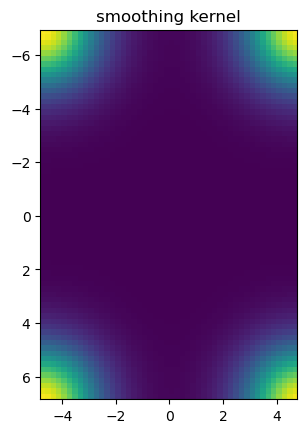

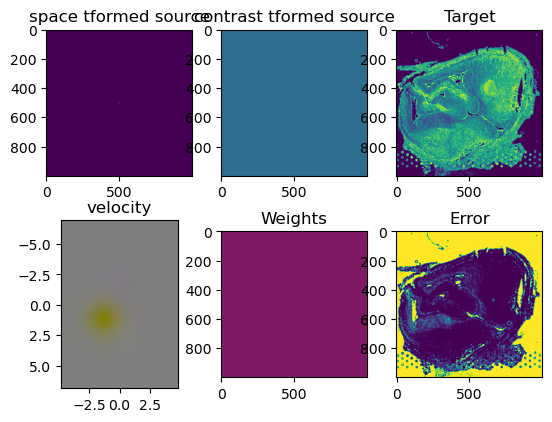

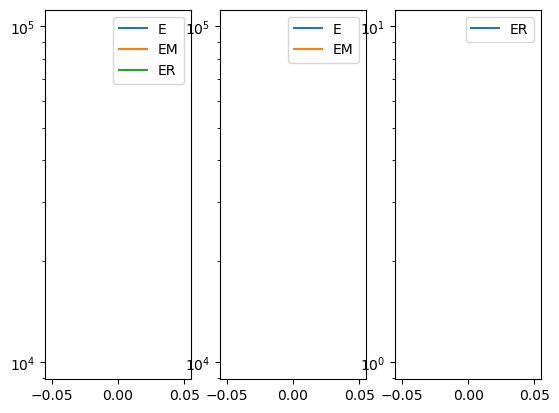

In [39]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=10,
    a=0.4,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
)


In [28]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

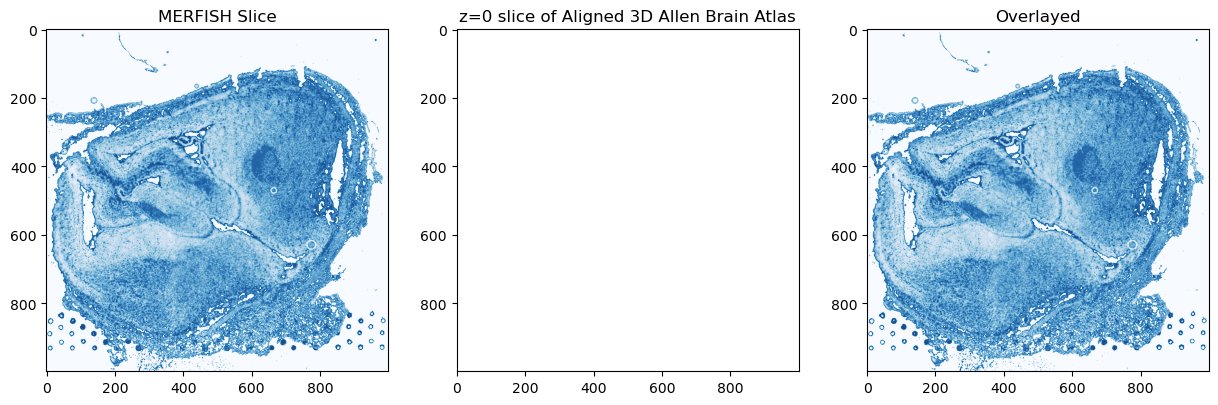

In [29]:
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.interp3D(xI,It,Xs.permute(3,0,1,2),padding_mode="border")
Ishow_source = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()

import matplotlib as mpl
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('MERFISH Slice')
ax1 = ax[1].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.2)
ax[1].set_title('z=0 slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax2 = ax[2].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()

In [11]:
I=nii_data[:,172,:]
I=np.array(I)
print("The initial shape of I is {}".format(I.shape))
I = np.vstack(([I], [I], [I])) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))


The initial shape of I is (379, 549)
The range of I is 0.0 to 11032.154296875
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 379, 549)


In [12]:

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

In [13]:
np.savez('../test/model',x=XI,y=YI,I=I)
np.savez('../test/visum', x=XJ,y=YJ,I=J)

In [14]:
# read from file
pointsIlist = np.load('../test/model_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('../test/visum_points.npy', allow_pickle=True).tolist()
print(pointsJlist)

{'a': [(423.57741129032274, 179.07809109911565), (404.1014791883456, 155.93278048517183), (391.11752445369416, 176.53775212929256), (430.63390842872025, 181.61843006893875), (383.214247658689, 123.7551535340792), (293.73786394380863, 190.08622663501578), (335.7945868886577, 191.77978594823117), (364.0205754422478, 190.65074640608756), (381.8029482310095, 188.95718709287218), (390.2707447970865, 202.7879214841313), (404.1014791883456, 225.08645244146743), (422.1661118626432, 199.68306274323638), (428.65808922996894, 195.73142434573379)], 'b': [(403.5369594172738, 246.53820374219583), (300.2298413111343, 161.29571831035395), (300.79436108220614, 218.5944750741417)]}
{'a': [(102.0537634408604, 449.9038978494623), (136.0591397849464, 643.586693548387), (162.67204301075276, 588.8823924731181), (87.26881720430129, 371.5436827956988), (140.4946236559142, 843.1834677419354), (721.5430107526886, 684.9845430107525), (496.8118279569894, 565.2264784946235), (337.13440860215064, 461.7318548387095),

In [15]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])
    
pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

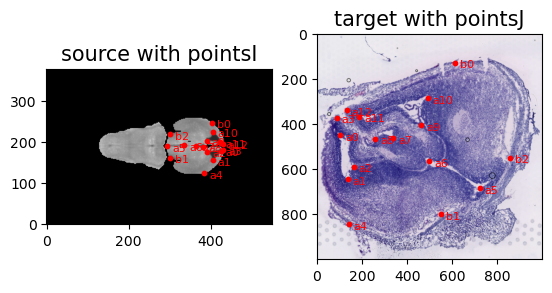

In [16]:
# plot
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))


fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)
    
for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)
        
ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

In [17]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [18]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsJ,pointsI)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

/home/albert/anaconda3/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Text(0.5, 1.0, 'target')

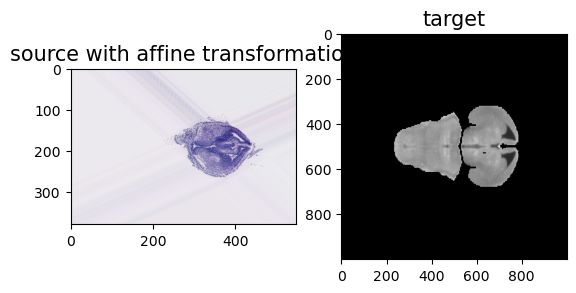

In [19]:
J=J.astype(float)
# compute initial affine transformation from points
AI= STalign.transform_image_source_with_A(A, [YJ,XJ], J, [YI,XI])

# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
#ax[0].imshow(AI[0], extent=extentI)
ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((I.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

In [20]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:] 
yIaffine = affine[0,:]


#apply A to sources landmark points in row, column (y,x) orientation
ypointsI = pointsI[:,0]
xpointsI = pointsI[:,1]
affine = np.matmul(np.array(A.cpu()),np.array([ypointsI, xpointsI, np.ones(len(ypointsI))]))

xpointsIaffine = affine[1,:] 
ypointsIaffine = affine[0,:]
pointsIaffine = np.column_stack((ypointsIaffine,xpointsIaffine))


# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xIaffine,yIaffine,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(pointsIaffine[:,1],pointsIaffine[:,0],c="blue", label='source landmarks aligned', s=100)
    
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])
    
ax.set_title('Landmark-based Affine Alignment', fontsize=15)


NameError: name 'yI' is not defined

Text(0.5, 1.0, 'Intensity Histogram of Source Image')

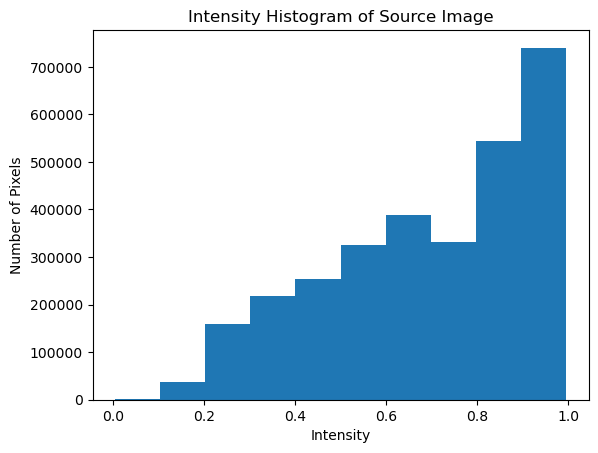

In [21]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Source Image')

In [22]:
WM = torch.ones(J[0].shape)*0.5
WB = torch.ones(J[0].shape)*0.4
WA = torch.ones(J[0].shape)*0.1
muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)

In [23]:
print(muA)
print(muB)

tensor([0.6564, 0.6299, 0.7730], dtype=torch.float64)
tensor([0.6564, 0.6299, 0.7730], dtype=torch.float64)


In [37]:
#muB = np.mean(I)
#muB = 0

#print(np.var(I[I>muB]))
#print(np.std(I[I>muB]))

#print(len(I[I>muB]))
#print(len(I[I<=muB]))

#print("Set sigmaM to be {:.2f}". format(np.std(I[I>muB])))
#print("Set sigmaB to be {:.2f}". format(np.std(I[I<=muB])))

#print(np.var(I[I<=muB]))
#print(np.std(I[I<=muB]))

#print("Set sigmaM to be the variance, {:.2f}". format(np.var(I)))
print("Set sigmaM, sigmaB, and sigmaA to be the standard deviation, {:.2f}". format(np.std(I)))


Set sigmaM, sigmaB, and sigmaA to be the standard deviation, 0.20


In [25]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

NameError: name 'out' is not defined

In [ ]:
fig,ax = plt.subplots()
ax.hist(I.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [26]:
print("Set sigmaM, sigmaB, and sigmaA to be the standard deviation, {:.2f}". format(np.std(I)))

Set sigmaM, sigmaB, and sigmaA to be the standard deviation, 0.20


In [27]:
WM = torch.ones(I[0].shape)*0.5
WB = torch.ones(I[0].shape)*0.4
WA = torch.ones(I[0].shape)*0.1
muA = torch.sum(WA*I,dim=(-1,-2))/torch.sum(WA)
muB = torch.sum(WB*I,dim=(-1,-2))/torch.sum(WB)

In [28]:
print(muA)
print(muB)

tensor([0.0782, 0.0782, 0.0782], dtype=torch.float64)
tensor([0.0782, 0.0782, 0.0782], dtype=torch.float64)


/home/albert/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/albert/Documentos/GitHub/STalign/docs/notebooks/../../STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 3min 53s, sys: 822 ms, total: 3min 54s
Wall time: 1min 13s


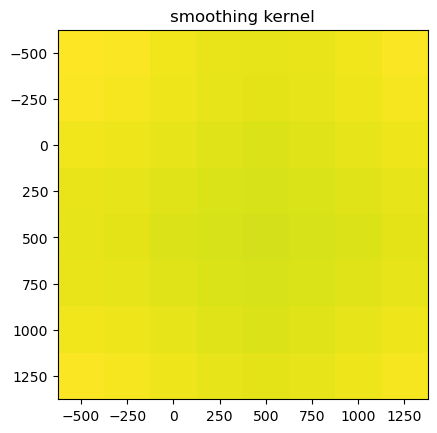

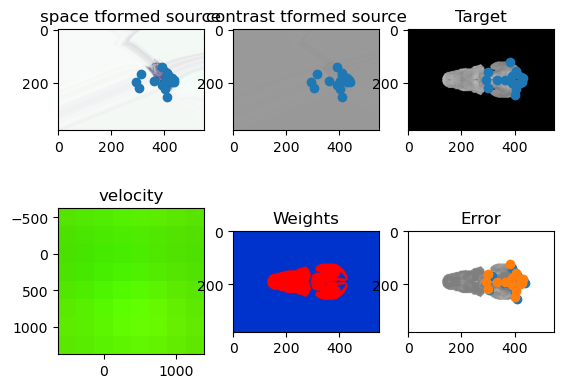

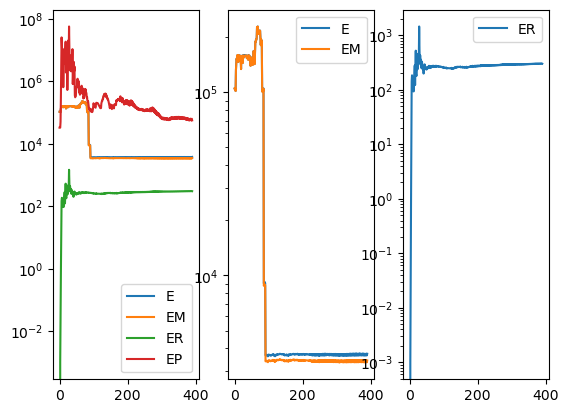

In [29]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 400,
          'pointsJ': pointsI,
          'pointsI': pointsJ,
          
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.2,
          'sigmaB': 0.2, 
          'sigmaA': 0.1e-4,
          'sigmaA': 0.2,
          'diffeo_start' : 10,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e-2
          }

# keep all other parameters default
# params = {'L':L,'T':T,
#           'niter': 200,
#           'pointsI': pointsI,
#           'pointsJ': pointsJ,
#           'device': device,
#           'sigmaP': 2e-1,
#           'sigmaM': 0.18,
#           'sigmaB': 0.18, 
#           'sigmaA': 0.18,
#           'diffeo_start' : 100,
#           'epL': 5e-11,
#           'epT': 5e-4,
#           'epV': 5e1
#           }

out = STalign.LDDMM([YJ,XJ],J,[YI,XI],I,**params)

In [30]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

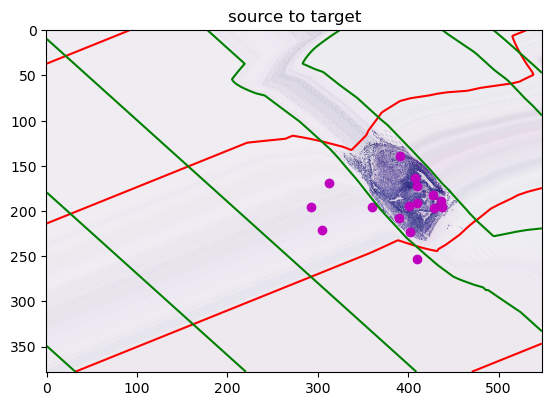

In [31]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsJ)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentI)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m")

In [32]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([YJ, XJ], 1))

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

In [33]:
v.shape

torch.Size([3, 8, 8, 2])

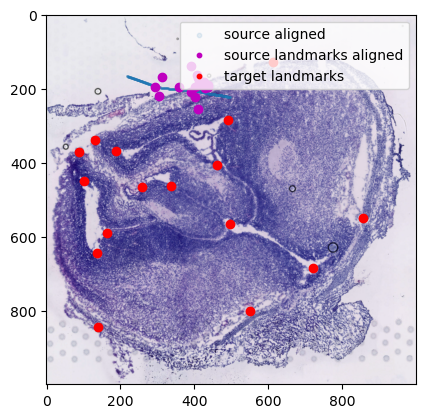

In [34]:
# plot
#fig,ax = plt.subplots()
#ax.imshow((I).transpose(1,2,0),extent=extentI)
#ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="r")
#ax.scatter(tpointsI[:,1].detach(),tpointsI[:,0].detach(),s=1,alpha=0.1)

# plot results
fig,ax = plt.subplots()
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m", label='source landmarks aligned')
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks')
ax.imshow((J).transpose(1,2,0),extent=extentJ)

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

In [35]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']



NameError: name 'transform' is not defined

In [ ]:
%%time
sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
muB = torch.tensor([0,0,0],device='cpu') #average of background intensities

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    XI,I,XJ,J,
    T=T,L=L,
    nt=4,niter=200,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
)